# Name: Siddhesh Badhan
Andrew ID: sbadhan

Task 1: Perform exploratory data analysis (for example, summary statistics and histograms on the 
numeric fields) on the sentiment field and indicate if you foresee any problems using the data 
to build a model to predict sentiment. 

In [1]:
import re                     #regular expressions
import string
import spacy              #natural language processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import itertools
import seaborn as sns

from nltk import tokenize # fast sentence tokenization
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [2]:
# Load data
data = pd.read_csv("/Twitter-sentiment-self-drive-DFE.csv", encoding='ISO-8859-1')

In [3]:
#Observe data
data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,our_id,sentiment_gold,sentiment_gold_reason,text
0,724227031,True,golden,236,NaN,5,0.7579,10001,5\n4,Author is excited about the development of the...,Two places I'd invest all my money if I could:...
1,724227032,True,golden,231,NaN,5,0.8775,10002,5\n4,Author is excited that driverless cars will be...,Awesome! Google driverless cars will help the ...
2,724227033,True,golden,233,NaN,2,0.6805,10003,2\n1,The author is skeptical of the safety and reli...,If Google maps can't keep up with road constru...
3,724227034,True,golden,240,NaN,2,0.8820,10004,2\n1,The author is skeptical of the project's value.,Autonomous cars seem way overhyped given the t...
4,724227035,True,golden,240,NaN,3,1.0000,10005,3,Author is making an observation without expres...,Just saw Google self-driving car on I-34. It w...


In [4]:
#Excluding the columns of unit state, sentiment gold and sentiment gold reason
df = data.drop(['_unit_state','sentiment_gold','sentiment_gold_reason'],axis = 'columns')
#Checking the data types of all the columns
df.dtypes

_unit_id                  int64
_golden                    bool
_trusted_judgments        int64
_last_judgment_at        object
sentiment                object
sentiment:confidence    float64
our_id                    int64
text                     object
dtype: object

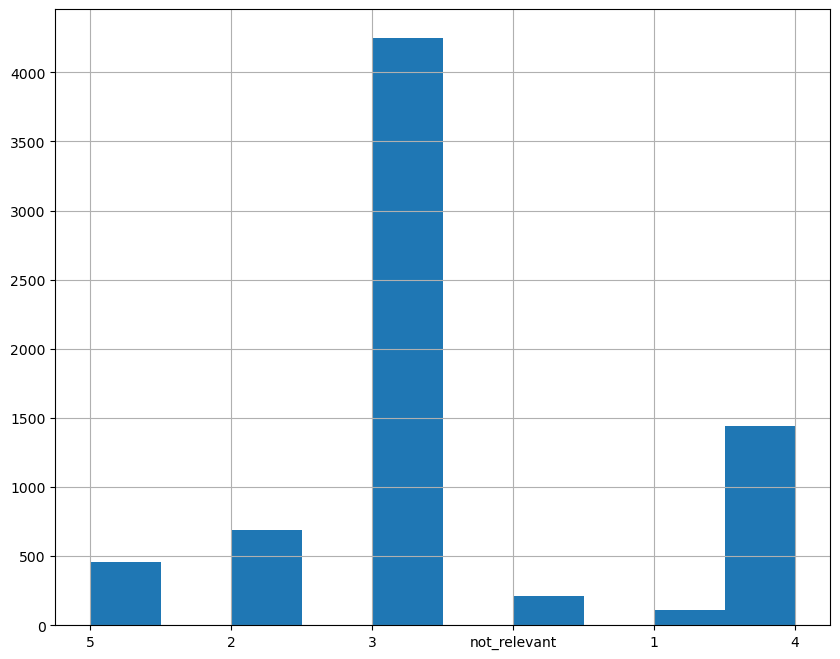

In [5]:
#Drawing the histogram of sentiment field
df['sentiment'].hist(bins=10, figsize=(10, 8))

# display the histograms
plt.show()

It can be seen that there is a problem with the sentiment field as it has some non-numeric values of not_relevant. This will cause problem while buiilding model to predict sentiment as it is non-numeric. Also the data type of the column is object which needs to be changed.
Hence the rows with not_relevant value have been changed to Nan and then these rows have been dropped as the sentiment has to be rated between 1 to 5.

In [6]:
#Replacing not_relevant values of sentiment field with nan.
df['sentiment'].replace('not_relevant', float('nan'), inplace=True)

#Dropping the rows with null values in sentiment field
df.dropna(subset=['sentiment'], inplace=True)

#Changing the data type of sentiment column to float
df['sentiment'] = df['sentiment'].astype(float)

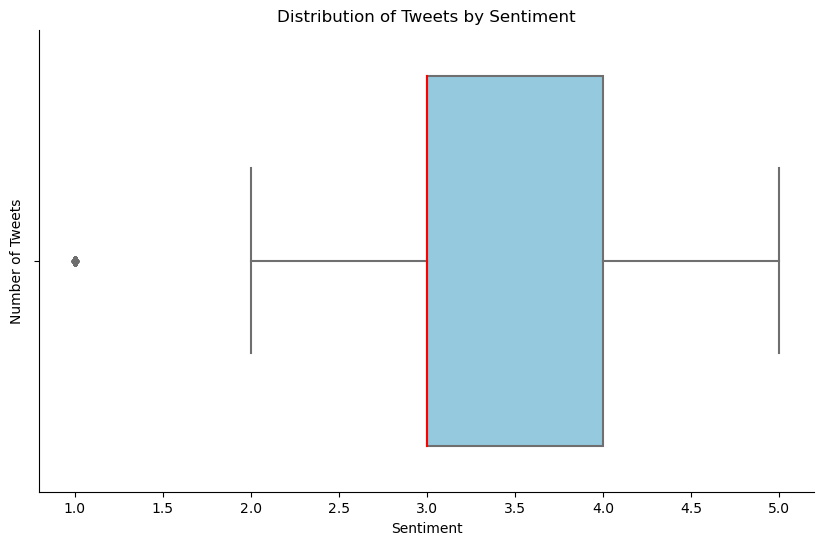

In [7]:
# Set figure size
plt.figure(figsize=(10, 6))

# Plot box plot with custom color and median line
sns.boxplot(x='sentiment', data = df, color='skyblue', medianprops={'color':'red'})

# Add x-axis label
plt.xlabel('Sentiment')

# Add y-axis label
plt.ylabel('Number of Tweets')

# Set plot title
plt.title('Distribution of Tweets by Sentiment')

# Set font size
plt.rcParams.update({'font.size': 12})

# Remove top and right spines
sns.despine()

# Show plot
plt.show()

In [8]:
#Observing the summary statistics of the dataset (numerical columns)
numerical_cols = df.select_dtypes(include='number').columns
df[numerical_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
_unit_id,6943.0,7.243440e+08,232506.698407,7.242270e+08,7.243229e+08,7.243247e+08,724326513.5,726942333.0
_trusted_judgments,6943.0,5.674204e+00,10.358088,2.000000e+00,3.000000e+00,4.000000e+00,8.0,241.0
sentiment,6943.0,3.209852e+00,0.768440,1.000000e+00,3.000000e+00,3.000000e+00,4.0,5.0
sentiment:confidence,6943.0,7.784352e-01,0.203988,2.505000e-01,6.334000e-01,7.539000e-01,1.0,1.0
our_id,6943.0,3.593300e+03,2113.448199,1.000000e+00,1.801500e+03,3.564000e+03,5331.5,10067.0


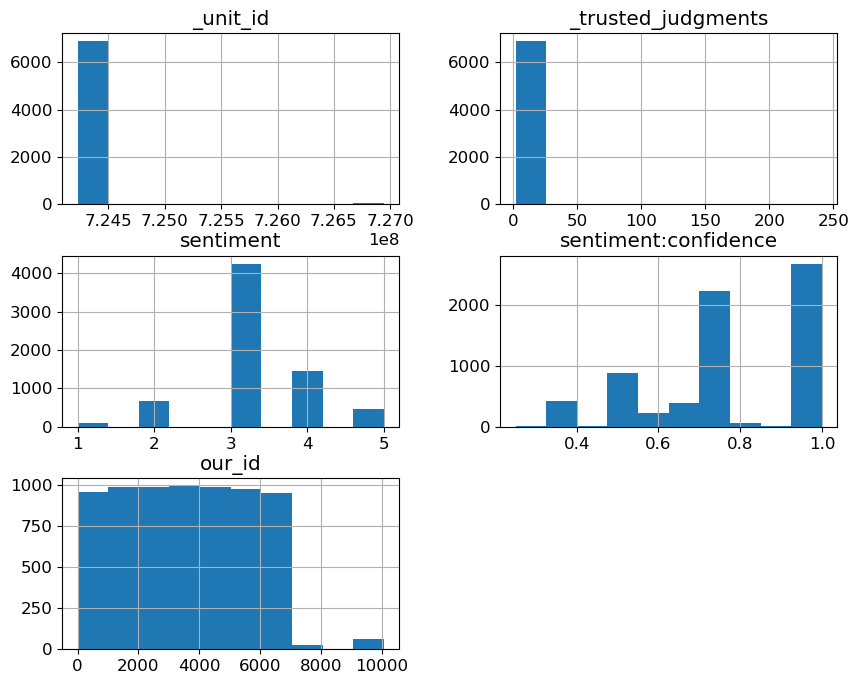

In [9]:
# create histograms of all numerical columns
df[numerical_cols].hist(bins=10, figsize=(10, 8))

# display the histograms
plt.show()

In [10]:
#Checking for null values in the dataset
df.isnull().sum()

_unit_id                 0
_golden                  0
_trusted_judgments       0
_last_judgment_at       64
sentiment                0
sentiment:confidence     0
our_id                   0
text                     0
dtype: int64

Task 2: Tokenize the Tweets in the text field for analysis. Remove the punctuation and hashtags. 
Perform stemming or lemmatization to get the roots of the tokens. Show the most common 
roots overall for all of the tweets. You should exclude stopwords and the frequent words/
phrases like “self-driving cars” that do not help in the prediction task. 

In [11]:
# Define a function to preprocess the text data
def preprocess_text(text):
    # remove punctuation and hashtags
    text = re.sub(r'[^\w\s#]', '', text)
    text = re.sub(r'#\w+', '', text)
    #ignoring the ascii characters
    text = text.encode('ascii', 'ignore').decode()
    # Convert text to lowercase
    text = text.lower()
    # Tokenize the text into words
    words = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    stop_words.update(['get', 'saw', 'like'])
    words = [word for word in words if word not in stop_words]
    # Perform lemmatization to get the root of each word
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Exclude frequent words/phrases like "self-driving cars"
    freq_words = ['selfdriving', 'selfdriving car', 'selfdriving cars', 'self', 'driving', 'car', 'cars']
    words = [word for word in words if word not in freq_words]
    return words

# Apply the preprocessing function to the text column
df['preprocess'] = df['text'].apply(preprocess_text)

# Flatten the list of tokens into a single list
tokens_list = [word for tokens in df['preprocess'] for word in tokens]

# Calculate the frequency of each token
token_frequency = nltk.FreqDist(tokens_list)

# Show the most common roots overall
print("Most common roots overall for all the tweets\n")
print(token_frequency.most_common(20))

Most common roots overall for all the tweets

[('google', 2947), ('driverless', 1860), ('vehicle', 359), ('autonomous', 354), ('future', 301), ('drive', 290), ('one', 283), ('road', 260), ('driver', 250), ('need', 234), ('uber', 234), ('new', 233), ('would', 232), ('could', 229), ('see', 211), ('want', 208), ('via', 208), ('rt', 205), ('make', 201), ('california', 200)]


Task 3: Create a model to predict what sentiment a Tweet will be given on the 1-5 scale. Note that 
you do not have to run any sentiment analysis packages (e.g. Vader or TextBlob) to build this 
model, just use the stemmed/lemmatized words in the text field as predictors of the sentiment 
score . What are the 10 top stemmed/lemmatized words for each sentiment rating? 

Model 1: Naive Bayes classifier

In [12]:
# Split data into training and testing sets
X = df['preprocess'].apply(lambda tokens: ' '.join(tokens))
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize text data
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Train model
model = MultinomialNB(alpha=0.1)
model.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = model.predict(X_test_vectorized)

# Get top words for each sentiment rating
feature_names = vectorizer.get_feature_names_out()
coefficients = model.coef_

for i in range(1, 6):
    top_features = np.argsort(coefficients[i-1])[-10:]
    print("Top words for sentiment {}: {}".format(i, ', '.join([feature_names[j] for j in top_features[::-1]])))

Top words for sentiment 1: driverless, would, google, never, dont, want, fuck, wtf, hell, crash
Top words for sentiment 2: google, driverless, dont, driver, think, people, one, drive, go, need
Top words for sentiment 3: google, driverless, vehicle, autonomous, uber, future, road, new, first, california
Top words for sentiment 4: google, driverless, cool, one, need, im, cant, drive, would, future
Top words for sentiment 5: google, driverless, awesome, want, cant, wait, cool, one, love, drive


/Users/siddhesh/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


In [13]:
# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

#print the confusion matrix
print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

#printi the classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 64.36%
Confusion Matrix:

[[  0   3  14   5   0]
 [  0  16  85  21   0]
 [  0  17 800  49   3]
 [  0   3 206  73   6]
 [  0   0  43  40   5]]
Classification Report:

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        22
         2.0       0.41      0.13      0.20       122
         3.0       0.70      0.92      0.79       869
         4.0       0.39      0.25      0.31       288
         5.0       0.36      0.06      0.10        88

    accuracy                           0.64      1389
   macro avg       0.37      0.27      0.28      1389
weighted avg       0.58      0.64      0.58      1389



/Users/siddhesh/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/siddhesh/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/siddhesh/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model 2: Logistic Regression

In [14]:
# Train model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_vectorized, y_train)

# Make predictions
y_pred_lr = lr.predict(X_test_vectorized)


# Get top words for each sentiment rating
feature_names_lr = vectorizer.get_feature_names_out()
coefficients_lr = lr.coef_

for i in range(1, 6):
    top_features_lr = np.argsort(coefficients_lr[i-1])[-10:]
    print("Top words for sentiment {}: {}".format(i, ', '.join([feature_names_lr[j] for j in top_features_lr[::-1]])))

Top words for sentiment 1: would, never, wtf, fuck, hell, crash, dont, driverless, trust, cause
Top words for sentiment 2: dont, doesnt, scare, problem, flaw, creepy, fbi, government, unemployment, point
Top words for sentiment 3: uber, wonder, apple, automated, spotted, get, here, inside, permit, google
Top words for sentiment 4: cool, wish, hurry, im, best, wow, better, thanks, pretty, nice
Top words for sentiment 5: awesome, amazing, excited, cool, wait, love, want, yes, incredible, exciting


In [15]:
# Evaluate model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Accuracy: {:.2f}%".format(accuracy_lr * 100))

#print the confusion matrix
print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

#print the classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_lr))

Accuracy: 66.81%
Confusion Matrix:

[[  0   3  14   5   0]
 [  0  16  85  21   0]
 [  0  17 800  49   3]
 [  0   3 206  73   6]
 [  0   0  43  40   5]]
Classification Report:

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        22
         2.0       0.35      0.06      0.10       122
         3.0       0.71      0.95      0.81       869
         4.0       0.45      0.28      0.35       288
         5.0       0.73      0.12      0.21        88

    accuracy                           0.67      1389
   macro avg       0.45      0.28      0.29      1389
weighted avg       0.61      0.67      0.60      1389



/Users/siddhesh/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/siddhesh/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/siddhesh/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


It can be seen that Model 2 (logistic regression) performs better as compared to the naive bayes classifier.
Looking at the confusion matrix of model-2, the model seems to perform poorly in predicting the first and fifth sentiment classes, with an F1-score of 0 for sentiment 1 and an F1-score of 0.21 for sentiment 5. This suggests that the model is struggling to distinguish between these classes and is misclassifying some of the tweets. This is because we observed in EDA that there is very less data available for sentiments 1 and 5.

To improve the model's performance, we can try the following:

1. Perform sentiment analysis using TextBlob and Vader. It will help in gaining a better understanding of the sentiment in the text. Using TextBlob or Vader can be beneficial as they can provide a quick and easy way to perform sentiment analysis on a large amount of text data.

2. Collect more data: It's possible that the model is not able to capture the nuances of sentiment in tweets due to a lack of sufficient data. Collecting more data could help to improve the model's performance.

3. Improve text preprocessing: The preprocessing steps such as stemming/lemmatization, removing stop words, and removing punctuation can have a significant impact on the model's performance. Experimenting with different preprocessing techniques may lead to better results.

4. Experiment with different models: We can try different machine learning models such as neural networks, support vector machines (SVM), or gradient boosting to see if they perform better than the current models.

5. Feature selection: We can experiment with selecting the most important features, i.e. words, by using techniques such as chi-squared test or mutual information to improve the model's performance.
